In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import chip8 as mp
import chip8_vec as vec
import chip8_vec_th as vec_th
import chip8_vec_th2 as vec_th2
import chip8_vec_jax as vec_jax


plt.rcParams["figure.figsize"] = [20, 8]
sns.set_theme()

In [4]:
game = "games/pong_1p.ch8"
modules = [
    "mp",
    "vec",
    "pytorch_cpu",
    "pytorch_gpu",
    "pytorch2_cpu",
    "pytorch2_gpu",
    "jax",
]
n_values = {
    module: [2**i for i in range(10)]
    if module == "mp"
    else [2**i for i in range(5)]
    if module == "jax"
    else [2**i for i in range(18)]
    for module in modules
}
max_cycles = 1_000

df = pd.DataFrame(
    columns=[
        "module",
        "n_emulators",
        "n_frames",
        "time",
        "effective_fps",
    ]
)

for module in modules:
    if module == "mp":
        main = mp.main_multiprocessing
    elif module == "vec":
        main = vec.main
    elif module == "pytorch_cpu":
        main = vec_th.main
        device = "cpu"
    elif module == "pytorch_gpu":
        main = vec_th.main
        device = "cuda"
    elif module == "pytorch2_cpu":
        main = vec_th2.main
        device = "cpu"
    elif module == "pytorch2_gpu":
        main = vec_th2.main
        device = "cuda"
    elif module == "jax":
        main = vec_jax.main

    for n_emulators in tqdm(n_values[module], desc=module):
        if module.startswith("pytorch"):
            dt = main(
                game,
                n_emulators=n_emulators,
                max_cycles=max_cycles,
                device=device,
            )
        else:
            dt = main(game, n_emulators=n_emulators, max_cycles=max_cycles)
        new_row = pd.DataFrame(
            [
                {
                    "module": module,
                    "n_emulators": n_emulators,
                    "n_frames": max_cycles // 8,
                    "time": dt,
                    "effective_fps": n_emulators * (max_cycles // 8) / dt,
                }
            ]
        )
        df = (
            new_row
            if df.empty
            else pd.concat([df, new_row], ignore_index=True)
        )
df

mp:   0%|          | 0/10 [00:00<?, ?it/s]/home/sevs/.pyenv/versions/3.13.0/lib/python3.13/multiprocessing/popen_fork.py:67: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/sevs/.pyenv/versions/3.13.0/lib/python3.13/multiprocessing/popen_fork.py:67: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
jax: 100%|██████████| 5/5 [03:17<00:00, 39.51s/it]


,module,n_emulators,n_frames,time,effective_fps
0,mp,1,125,0.124421,1004.653370
1,mp,2,125,0.158806,1574.246000
2,mp,4,125,0.258498,1934.254638
3,mp,8,125,0.458165,2182.617807
4,mp,16,125,0.860525,2324.162545
...,...,...,...,...,...
100,jax,1,125,29.469537,4.241668
101,jax,2,125,33.750789,7.407234
102,jax,4,125,33.709855,14.832458
103,jax,8,125,45.122181,22.162049


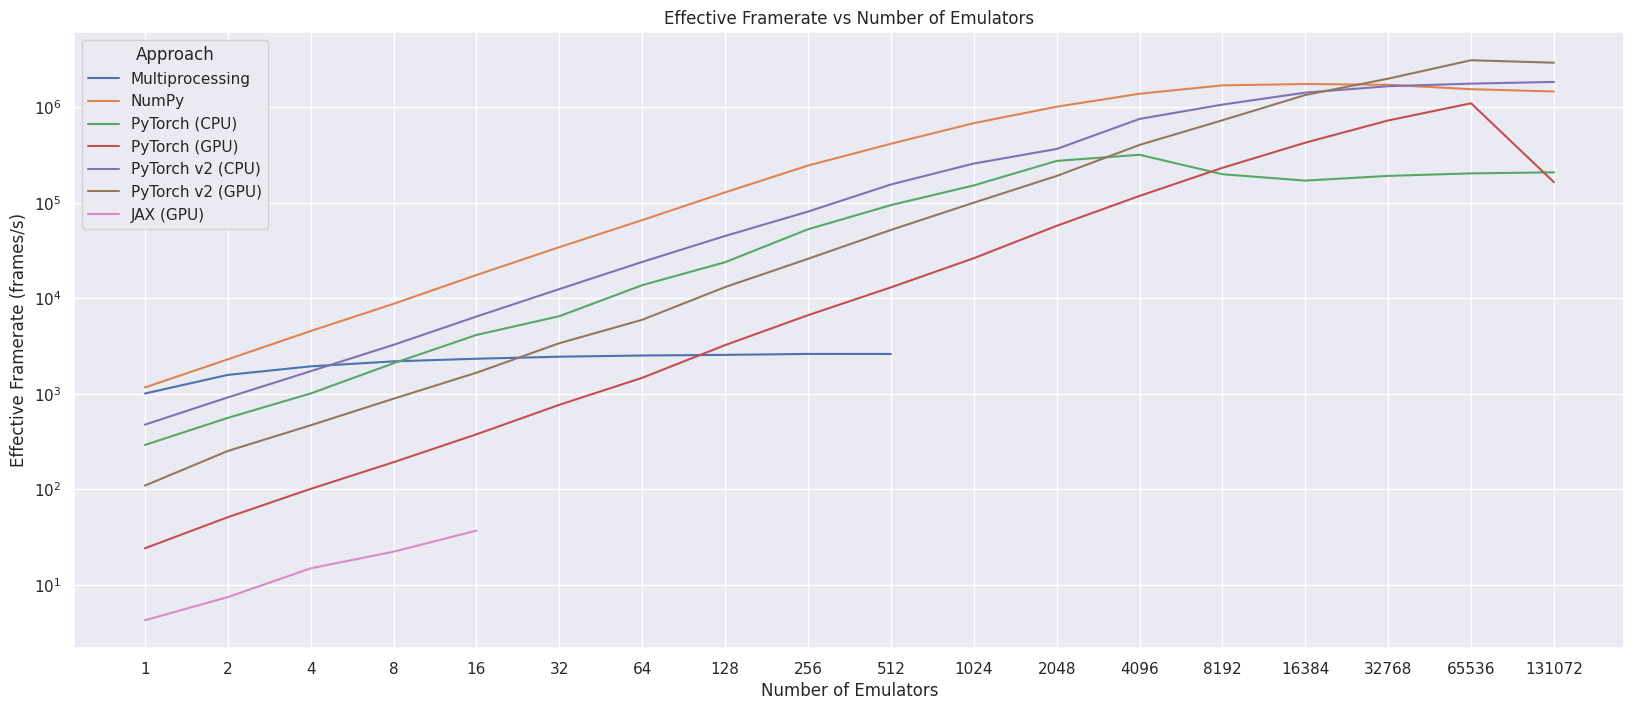

In [5]:
df["approach"] = df["module"].replace(
    {
        "mp": "Multiprocessing",
        "vec": "NumPy",
        "pytorch_cpu": "PyTorch (CPU)",
        "pytorch_gpu": "PyTorch (GPU)",
        "pytorch2_cpu": "PyTorch v2 (CPU)",
        "pytorch2_gpu": "PyTorch v2 (GPU)",
        "jax": "JAX (GPU)",
    }
)

ax = sns.lineplot(data=df, x="n_emulators", y="effective_fps", hue="approach")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xticks(n_values["vec"])
ax.set_xticklabels(n_values["vec"])
ax.legend(title="Approach", loc="upper left")

plt.xlabel("Number of Emulators")
plt.ylabel("Effective Framerate (frames/s)")
plt.title("Effective Framerate vs Number of Emulators")
plt.show()